In [1]:
import pandas as pd
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_row',10000)
pd.set_option('display.max_columns',40)

### Importação do dataset

**OBS** Essa parte do trabalho foi baseada no [estudo de previsão de irradiância solar usando Regressão por vetores de suporte](https://repositorio.ufc.br/bitstream/riufc/45060/3/2018_tcc_jlogomes.pdf). Gomes, Jan Luccas de Oliveira

In [3]:
df = pd.read_csv('Dados/data_tratado.csv',sep=';')
df.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')

In [4]:
def tirando_horas_sem_radiacao(df):
    condicao_irradiacao = (df.HORA<=18) & (df.HORA>=5)
    df = df[condicao_irradiacao]
    return df


ts = tirando_horas_sem_radiacao(df)
ts.loc[:,'DT_MEDICAO'] =  pd.to_datetime(df.loc[:,'DT_MEDICAO'], format='%Y-%m-%d')
ts.loc[:,'MES'] = ts.loc[:,'DT_MEDICAO'].dt.month
#criando a coluna ano
ts.loc[:,'ANO'] = ts.loc[:,'DT_MEDICAO'].dt.year
ts_dia = ts.groupby('DT_MEDICAO').agg({'RAD':'sum','CHUVA':'sum','ANO':'mean','MES':'mean','PRE_INS':'mean','UMD_MIN':'mean','PTO_MIN':'mean','VEN_DIR':'mean','TEM_MAX':'mean'})

ts.set_index('DT_MEDICAO',inplace=True)

In [5]:
# funçãoque cria a janela d previsão com N elementos

def create_lags(df,N):
    for i in range(N):
        df['Lag'+str(i+1)] = df.RAD.shift(i+1)
    return df

In [6]:
ts['day'] = ts.index.day
ts['dayofyear'] = ts.index.dayofyear
ts['weekday'] = ts.index.weekday
ts['weekofyear'] = ts.index.weekofyear

ts['month'] = ts.index.month
ts['is_month_start'] = ts.index.is_month_start
ts['is_month_end'] = ts.index.is_month_end

ts['year'] = ts.index.year
ts['is_year_start'] = ts.index.is_year_start
ts['ano_fim'] = ts.index.is_year_end

ts['quarter'] = ts.index.quarter
ts['quarter_comeco'] = ts.index.is_quarter_start
ts['quarter_fim'] = ts.index.is_quarter_end

ts['ts_lag1'] = ts.RAD.shift()

ts = ts.dropna()

In [7]:
# No trabalho a captação de dados eram de 10 em 10 minutos então fez um lag de 60 (1hora)
# nossa captação é de hora em hora então faremos lag de 24h
ts = create_lags(ts,14)
ts= ts.dropna()
ts_copy = ts.copy()
ts.head()

,DC_NOME,PRE_INS,TEM_SEN,VL_LATITUDE,PRE_MAX,UF,RAD_GLO,PTO_INS,TEM_MIN,VL_LONGITUDE,UMD_MIN,PTO_MAX,VEN_DIR,CHUVA,PRE_MIN,UMD_MAX,VEN_VEL,PTO_MIN,TEM_MAX,VEN_RAJ,...,is_year_start,ano_fim,quarter,quarter_comeco,quarter_fim,ts_lag1,Lag1,Lag2,Lag3,Lag4,Lag5,Lag6,Lag7,Lag8,Lag9,Lag10,Lag11,Lag12,Lag13,Lag14
DT_MEDICAO,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-02,SAO PAULO - MIRANTE,924.4,24.4,-23.496294,924.4,SP,48.201,16.2,24.7,-46.620088,58.0,16.3,340.0,0.0,923.9,59.0,1.8,16.2,25.0,5.3,...,False,False,1,False,False,0.000,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567,115.361
2015-01-02,SAO PAULO - MIRANTE,925.2,24.7,-23.496294,925.2,SP,285.042,16.6,24.8,-46.620088,58.0,16.7,330.0,0.0,924.4,60.0,1.9,16.2,25.3,5.5,...,False,False,1,False,False,48.201,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737,732.567
2015-01-02,SAO PAULO - MIRANTE,925.7,24.8,-23.496294,925.7,SP,834.522,16.8,25.3,-46.620088,55.0,17.2,318.0,0.0,925.2,59.0,2.8,16.5,26.6,5.1,...,False,False,1,False,False,285.042,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176,1597.737
2015-01-02,SAO PAULO - MIRANTE,926.2,27.7,-23.496294,926.2,SP,1136.050,17.6,26.4,-46.620088,52.0,17.6,319.0,0.0,925.7,56.0,1.5,16.7,27.8,5.3,...,False,False,1,False,False,834.522,834.522,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439,2405.176
2015-01-02,SAO PAULO - MIRANTE,926.1,28.4,-23.496294,926.2,SP,2073.788,17.5,27.8,-46.620088,47.0,18.0,290.0,0.0,926.0,54.0,2.7,16.6,29.7,7.2,...,False,False,1,False,False,1136.050,1136.050,834.522,285.042,48.201,0.000,125.110,1724.781,2137.269,2752.190,3008.730,3682.655,3576.775,3485.912,2828.439


### Visualizando quais são as que mais tem correlação com a coluna RAD

In [8]:
display(df.corr(method='spearman')['RAD'].sort_values(ascending=True))

UMD_INS        -0.598736
UMD_MIN        -0.585439
UMD_MAX        -0.509634
PTO_MIN        -0.133893
CHUVA          -0.082896
PTO_INS        -0.074575
PRE_INS        -0.056892
PRE_MIN        -0.041365
PRE_MAX        -0.033494
PTO_MAX         0.014987
HORA            0.114067
VEN_DIR         0.223542
VEN_VEL         0.278706
VEN_RAJ         0.299308
TEM_SEN         0.394779
TEM_MIN         0.447586
HR_MEDICAO      0.525819
TEM_MAX         0.535968
TEM_INS         0.536815
RAD_GLO         0.943172
RAD             1.000000
VL_LATITUDE          NaN
VL_LONGITUDE         NaN
Name: RAD, dtype: float64

### Baseado no trabalho

In [9]:
cols = ['TEM_INS', 'UMD_INS','VEN_RAJ', 'CHUVA','HORA','day', 'dayofyear', 'weekday', 'weekofyear', 'month',
        'is_month_start', 'is_month_end', 'year', 'is_year_start', 'ano_fim','quarter', 'quarter_comeco', 
        'quarter_fim', 'Lag1', 'Lag2', 'Lag3','Lag4', 'Lag5', 'Lag6', 'Lag7', 'Lag8', 'Lag9', 'Lag10', 'Lag11',
        'Lag12', 'Lag13', 'Lag14']


In [16]:
# Define X e saídas Y e divide em 70% para treino e 30% pra teste

X = ts[cols]

y=np.log(ts['RAD']+1)  # log de y +1 pra não dar problema se zero!
X.shape, y.shape

((35783, 32), (35783,))

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42)

In [18]:
X_train.shape ,X_test.shape

((23974, 32), (11809, 32))

In [19]:
y_train.shape, y_test.shape

((23974,), (11809,))

In [20]:
# Define pipeline
pipe = Pipeline([('minmax', MinMaxScaler()),
                    ('reg', SVR(kernel='rbf', C=1.0, epsilon=0.01))])

In [21]:
#Cria uma SVR, treina e prediz os valores
# Ajusta o modelo nos dados de treino
from sklearn import set_config
set_config(display='diagram')

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)
y_hat= pipe.predict(X_train)

In [22]:
a_test = pipe.score(X_test, y_test)
a_train = pipe.score(X_train, y_train)
print(f'O acurácia do  test é {a_test.round(3)}, e do train é {a_train.round(3)}')
MSE_test = mean_squared_error(y_test, y_pred,squared=False)
MSE_train = mean_squared_error(y_train, y_hat,squared=False)
print(f'O MSE do  test é {MSE_test.round(3)}, e do train é {MSE_train.round(3)}')

O acurácia do  test é 0.939, e do train é 0.941
O MSE do  test é 0.642, e do train é 0.627


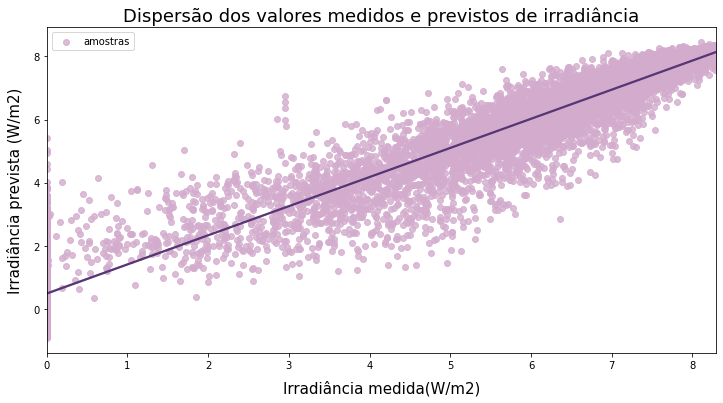

In [23]:
#p = np.array([0,40])
fig = plt.figure(figsize=(12, 6))
fig.set_facecolor("#fff")
ax = fig.add_subplot()
ax.set_facecolor("#fff")
plt.title('Dispersão dos valores medidos e previstos de irradiância',fontsize=18)
#ax =sns.regplot(p,p,color='#75d2dc',label='previsto=medido')
ax=sns.regplot(y_test, y_pred,color='#d3accd',label='amostras',line_kws={'color':'#563674'})
ax.set_ylabel('Irradiância prevista (W/m2)', fontsize=15, fontweight="normal", labelpad=10)
ax.set_xlabel('Irradiância medida(W/m2)', fontsize=15, fontweight="normal", labelpad=10)
plt.legend(loc='upper left');

In [25]:
# função que  calcula o erro percentual para cada previsão, em que 
## erro =vetor de erros percentuais para cada amostra  - essa função é igual a do estudo seguido

def erro(test,pred):
    erro=np.repeat(0,len(test))
    for i in range(len(test)):
        if test[i]==0:
            erro[i]=0
        else:
            erro[i]=100*(np.abs(test[i]-pred[i]))/test[i]
    return erro

In [26]:
erro = erro(y_test,y_pred)
erro

array([0, 0, 2, ..., 2, 0, 1])

In [27]:
erro.mean(), erro.std() # Erro está errando pra mais pois mean>0 e std alto, ou seja, tem um/uns valores descrepantes

(11.330171902786011, 181.802292735295)

In [28]:
pd.DataFrame(erro).describe().T

,count,mean,std,min,25%,50%,75%,max
0,11809.0,11.330172,181.809991,0.0,0.0,2.0,7.0,10993.0


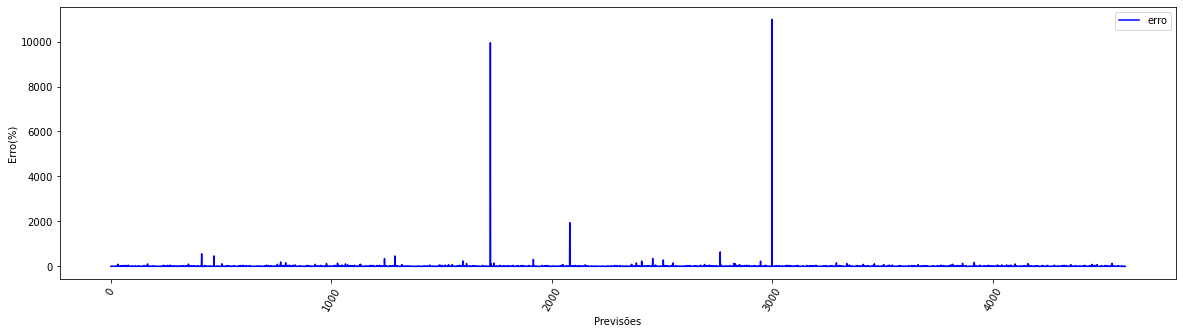

In [29]:
plt.figure(figsize=(20,5))
plt.plot( erro[0:4601], color='blue', label='erro')
plt.xlabel('Previsões')
plt.xticks(rotation=60)
plt.ylabel('Erro(%)')
plt.legend();

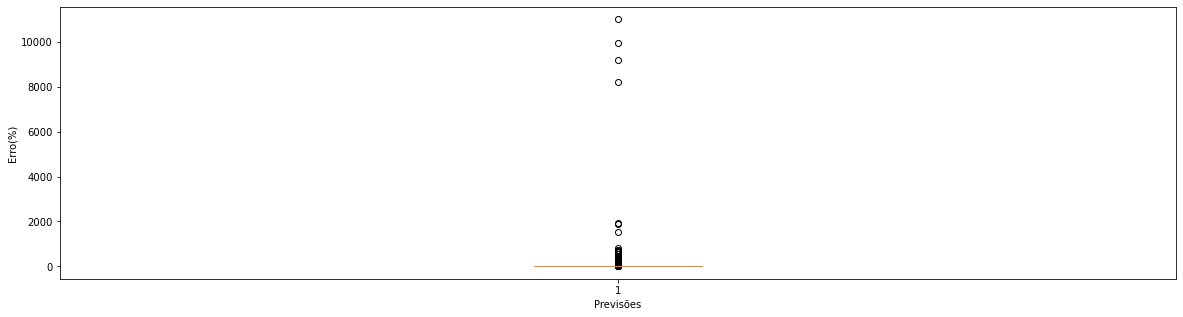

In [30]:
plt.figure(figsize=(20,5))
plt.boxplot( erro)
plt.xlabel('Previsões')
plt.ylabel('Erro(%)');

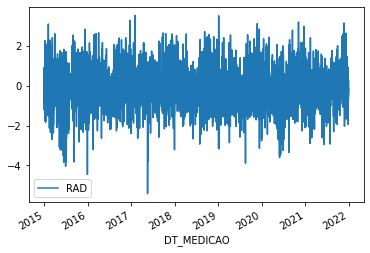

In [31]:
resid = y_test-y_pred
pd.DataFrame(resid).plot();

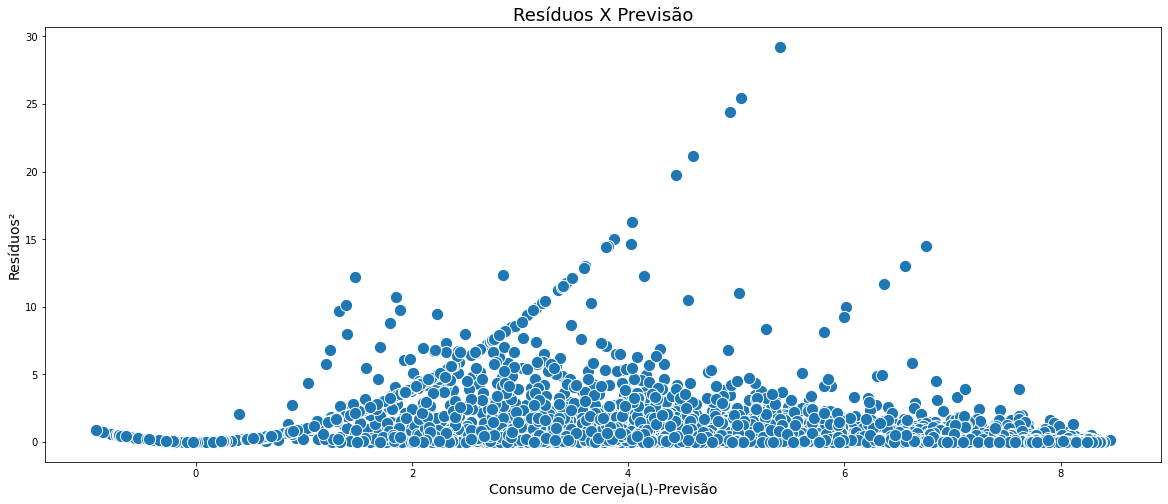

In [32]:
ax = sns.scatterplot(x=y_pred,y=resid**2,s=150) 
ax.figure.set_size_inches(20,8)
ax.set_title('Resíduos X Previsão',fontsize=18)
ax.set_xlabel('Consumo de Cerveja(L)-Previsão',fontsize=14)
ax.set_ylabel('Resíduos²',fontsize=14);

In [33]:
resid2 = y_train - y_hat

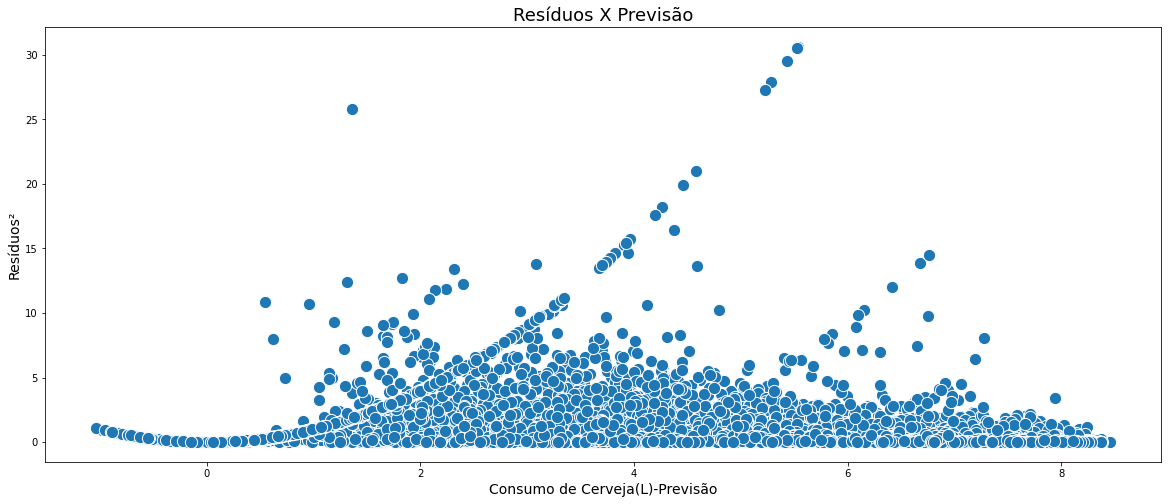

In [35]:
ax = sns.scatterplot(x=y_hat,y=resid2**2,s=150) 
ax.figure.set_size_inches(20,8)
ax.set_title('Resíduos X Previsão',fontsize=18)
ax.set_xlabel('Consumo de Cerveja(L)-Previsão',fontsize=14)
ax.set_ylabel('Resíduos²',fontsize=14);

In [36]:
#função que calcula os erros menos ou iguais a n % em que
## err= vetor de erros percentuais

def percent_erro(erro,n):
    cont=0
    for i in range(len(erro)):
        if erro[i]<=n:
            cont=cont+1
    return 100*cont/(len(erro))       

In [37]:
# função que calcula os erros menores que %n entre período de horas
## em que :  hor=vetor de horas
##           h_ini = hora inicial
##           h_fin = hora final

def percent_erro_hora(erro=erro, hor = df['HORA'], h_ini=None,h_fin=None,n=None):
    cont_erro = 0
    cont_hora = 0
    for i in range(len(erro)):
        if hor.iloc[i]>=h_ini and hor.iloc[i]<h_fin:
            cont_hora = cont_hora+1
            if erro[i]<=n:
                cont_erro=cont_erro+1
                
    return 100*cont_erro/cont_hora


In [38]:
percent_erro(erro[0:10],5) # 10% dos erros são abaixo ou igual a 5% - no estudo 39,74%

70.0

In [39]:
p_erro = [5,10,15]

for e in p_erro:
    er = percent_erro(erro,e) 
    print(f' {er :.2f}% das previsões tiveram um erro de até {e}%')  
    # no estudo foi respectivamente: 39,74%, 54,17% e 62,78%

 71.68% das previsões tiveram um erro de até 5%
 83.32% das previsões tiveram um erro de até 10%
 89.02% das previsões tiveram um erro de até 15%


In [40]:
p_erro = [5,10,15]

for e in p_erro:
    er = percent_erro_hora(erro,h_ini=10, h_fin=16,n=e)
    print(f' {er :.2f}% das previsões tiveram um erro de até {e}% entre as 10:00 às 16:00')
    # no estudo 54,44%, 63,88% e 74,44% 

 72.80% das previsões tiveram um erro de até 5% entre as 10:00 às 16:00
 84.38% das previsões tiveram um erro de até 10% entre as 10:00 às 16:00
 89.09% das previsões tiveram um erro de até 15% entre as 10:00 às 16:00


In [41]:
# Cálculo do erro médio quadrático 

rmse = sqrt(mean_squared_error(y_test, y_pred))
rmse

0.641585761158516

In [42]:
# Cálculo do coeficiente de determinação R2
r2_score(y_test,y_pred)

0.9388712484327877

In [43]:
# função para cálculo do erro médio quadrático normalizado, em que:
## test = dados medidos do período de teste
## pred = dados previstos para o período de teste

def n_rmse(test, pred):
    erro=np.repeat(0, len(test))
    media = (sum(test)/len(test))
    soma = 0
    for i in range(len(test)):
        erro[i]=((pred[i]-test[i])/(media))**2
        soma=soma+erro[i]
    return 100*(soma/(len(test)))**(1/2)


In [44]:
n_rmse(y_test,y_pred)

0.0